# PROJECT: Course Optimization for Data Science
## Optimization strategies for robust regression


Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradients of the Huber model
- Implement your own solvers for L1 or squared L2 regularization with: (Accelerated) Proximal gradient descent, Proximal coordinate descent and L-BFGS (only for L2).
- Implement your own scikit-learn estimator for the Huber model and test it against the Ridge and Lasso from scikit-learn on some real data.
- You are expected to provide clear figures as one could expect from an experiment section in a research paper.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 31st of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "manon"
ln1 = "rivoire"
fn2 = "alexis"
ln2 = "gerbeaux"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_rivoire_manon_and_gerbeaux_alexis.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

## Part 0: Why a robust regression model


Let us consider the problem of regression from $n$ observations
$x_i \in \mathbb{R}^{p}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{p}\mapsto y\in\mathbb{R}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^p \times \mathbb{R}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

The types of model we consider in this project are so-called *robust models* that can deal with samples corrupted by strong artifacts.

Let's generate such a dataset in 1D to illustrate the problem when using the squared loss ($\|\cdot\|^2$).

coef = 38.644
intercept = 9.919


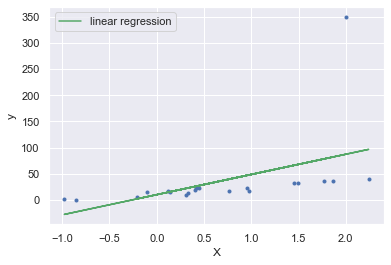

In [3]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# Generate toy data
X, y = make_regression(n_samples=20, n_features=1, random_state=0, noise=4.0, bias=10.0)

# Add an outlier
X[0, 0] = 2.
y[0] = 350

# Fit the model
reg = LinearRegression()
reg.fit(X, y)

# Visualize the model
x = X[:, 0]
y_pred = reg.coef_ * x + reg.intercept_
print('coef = %.3f' %reg.coef_[0])
print('intercept = %.3f' %reg.intercept_)

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

Les vrais paramètres qui ont générés les données (sans outlier) sont :<br>
- coef = 14.335... <br>
- intercept = 10

<div class="alert alert-success">
    <b>QUESTION 0:</b>
     <ul>
       <li>Describe the issue you observe and suggest an explanation and a possible solution.</li>
    </ul>
</div>

<font color='blue'>
    
- The linear model is not properly fitting our data, as the slope is clearly too high. This is due to the outlier we added to the model.
- The way parameters (slope and intercept) are estimated is not robust. They are estimated through the ordinary least squares method trying to minimize the sum of squares. Consequently, the outlier will result in a square term larger than the others and will significantly change the linear interpolation. The mean is not a robust statistic, the median is better but it is a positioning statistic and not a continuous statistic.
- Outliers can be of two types: influential points or leverage points. Here the outlier is an influential point as it influences the slope of the regression line.
- A possible solution would be to eliminate outliers before fitting the linera model.
    
</font>

## Part 1: Huber Loss

One version of the Huber function ($H_\epsilon : \mathbb{R} \rightarrow \mathbb{R}$) reads:

$$
    H_\epsilon (x) = \left\{
	\begin{aligned}
	x^2 & \quad \mathrm{ if } \quad |x| < \epsilon \\
    2 \epsilon |x| - \epsilon^2 & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

Working in a regression setting, the Huber loss between 2 targets $y$ and $y'$ reads:

$$
    \mathcal{L}(y, y') = H_\epsilon (y - y')
$$

Here is an implemention of the Huber function:

In [4]:
epsilon = 1.

def huber(x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = x[mask] ** 2
    z[~mask] = 2 * epsilon * np.abs(x[~mask]) - epsilon ** 2
    return z

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
       <li>Plot the Huber function vs. the squared function ($x \rightarrow x^2$) vs. the absolute value function ($x \rightarrow |x|$) between -3 and 3 using $\epsilon = 1$</li>
    </ul>
</div>

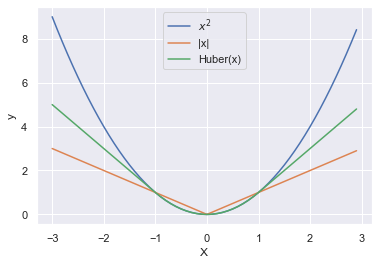

In [5]:
### TODO
x = np.arange(-3, 3, 0.1)
x2 = x**2
xabs = np.abs(x)
xhub = huber(x, epsilon=1)

plt.plot(x, x2, label="$x^2$")
plt.plot(x, xabs, label="|x|")
plt.plot(x, xhub, label='Huber(x)')
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.show()
### END TODO

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
       <li>Justify the convexity of the Huber function as defined above.</li>
       <li>Justify the smoothness of the Huber function as defined above and propose a value for the Lipschitz constant of its gradient.</li>
    </ul>
</div>

<font color='blue'>
    
- **Convexity**
<br>
Let show that $H_\epsilon(x) = \sup_{|y|\leq \epsilon}\left\{ 2yx-y^2 \right\}$
<br>
First let note that $y \rightarrow 2yx-y^2 = y \left( 2x-y \right) $ is strictly concave and reaches its maximum for $y=x$.
<br>
1. If $|x|<\epsilon$:
<br>
The maximum is reached for $y=x$ so $|y|\leq \epsilon$ and the maximum is $2x^2 - x^2 = x^2$.
<br>
2. If $x>\epsilon$:
<br>
The maximum reached in $y=x$ doesn't not satisfie the constrain $|y|\leq \epsilon$. Under this constrain, the maximim is reached for $y=\epsilon$. So the maximim is $2\epsilon x - \epsilon^2$.
<br>
3. If $x<-\epsilon$:
<br> 
The same arguments as before give us that the maximum is $-2\epsilon x - \epsilon^2$.
<br>
Thus, we have :
$$
    \sup_{|y|\leq \epsilon}\left\{ 2yx-y^2 \right\} = \left\{
	\begin{aligned}
	x^2 & \quad \mathrm{ if } \quad |x| < \epsilon \\
    2 \epsilon x - \epsilon^2 & \quad \mathrm{ if } x > \epsilon \\
    - 2 \epsilon x - \epsilon^2 & \quad \mathrm{ if } x < -\epsilon
	\end{aligned}
    \right.
$$
So $\sup_{|y|\leq \epsilon}\left\{ 2yx-y^2 \right\} = H_\epsilon(x)$ and as a supremum of convex function (because affine function) is convex. By consequence, $H_\epsilon$ is convex.
 
    
- **Smoothness**   
Case distinction : <br/>
1. If $|x| \leq \epsilon$ and $|y| \leq \epsilon$ <br/>

\begin{equation}
  \left\| \nabla H_{\epsilon}(x) - \nabla H_{\epsilon}(y)  \right\| = \left\|2x - 2y \right\| = 2 \left\|x - y\right\|
\end{equation}

2. If $|x| \leq \epsilon$ and $y > \epsilon$ (same if $|x| \leq \epsilon$ and $y < - \epsilon$) <br/>

\begin{equation}
  \left\| \nabla H_{\epsilon}(x) - \nabla H_{\epsilon}(y)  \right\| = \left\|2x - 2\epsilon \right\| = 2 \left\|x - \epsilon \right\| \leq 2 \left\|x - \epsilon \right\| 
\end{equation}

3. If $x \leq - \epsilon$ and $y > \epsilon$ <br/>
\begin{equation}
  \left\| \nabla H_{\epsilon}(x) - \nabla H_{\epsilon}(y)  \right\| = \left\|2\epsilon - 2y \right\| = 2 \left\| \epsilon - y \right\| \leq 2 \left\|x - y \right\| 
\end{equation}

4. If $x > \epsilon$ and $y > \epsilon$ (same if $x < - \epsilon$ and $y < - \epsilon$) <br/>
\begin{equation}
  \left\| \nabla H_{\epsilon}(x) - \nabla H_{\epsilon}(y)  \right\| = \left\|2\epsilon - 2\epsilon \right\| = 2 \left\| \epsilon - \epsilon \right\| = 0 \leq 2 \left\|x - y \right\| 
\end{equation}

Consequently, we have proved that the Huber Loss is $L$-Smooth with $L = 2$

<font>

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
       <li>Write a function that computes the gradient of the Huber loss.</li>
    </ul>
</div>

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the Huber function (not just in one location).

In [6]:
### TODO
def grad_huber(x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = 2*x[mask]
    z[~mask] = 2 * epsilon * np.sign(x[~mask])
    return z
### END TODO

Check the gradient for both the linear and quadratic regions

In [7]:
pt_test_region1 = np.array([np.random.uniform(low=-100, high=-epsilon)])
pt_test_region2 = np.array([np.random.uniform(low=-epsilon, high=epsilon)])
pt_test_region3 = np.array([np.random.uniform(low=epsilon, high=100)])
pt_test_region1[0], pt_test_region2[0], pt_test_region3[0]

(-40.3111777550254, 0.6674417494819556, 38.61930837760617)

In [8]:
from scipy.optimize import check_grad

check_grad(huber, grad_huber, pt_test_region1), check_grad(huber, grad_huber, pt_test_region2), check_grad(huber, grad_huber, pt_test_region3)

(0.0, 1.58278159467784e-08, 0.0)

Let us define the cost function associated to the empirical risk with some regularization function $\mathcal{R}$:

$$
    (\mathcal{P}_{f,\mathcal{R}}):
	\begin{aligned}
	\min_{w \in \mathbb{R}^p, b \in \mathbb{R}} \quad \frac{1}{n} \sum_{i=1}^n f(y_i - x_i^\top w - b) + \lambda \mathcal{R}(w) \enspace ,
	\end{aligned}
$$

where $f$ is a scalar function defining the loss (Huber, squared, absolute etc.). The variable $b$ is the bias or intercept term.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Let us consider for $\mathcal{R}$ either the $\ell_1$ norm ($\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^p |w_j|$) or the squared $\ell_2$ norm ($\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^p w_j^2)$. Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable, depending on the choice of $\mathcal{R}$ when $f$ is the Huber function as defined above.</li>
    </ul>
</div>

<font color='blue'>

- L-BFGS-B Algorithm

The L1-norm makes it difficult to use a method that relies on a quadratic approximation of the function to minimize, as the L1-norm is not differentiable everywhere. Therefore L-BFGS-B Algorithm may not be the most suiteable method in the case of a L1-regularization. <br/>
If we use the L2-norm, we can reasonably use the L-BFGS-B algorithm. The regularization is quadratic and the Huber function is twice differentiable almost everywhere. An approximation of the hessian is computed and line search method can be used to find the best step size. <br/>

- Gradient Descent Algorithm 

The Huber function is smooth but the L1-norm is not. So using classical gradient descent algorithm with the L1 regularization is not suitted. <br/>
However with the **L2-norm**, which is convex and smooth, the use of **gradient descent algorithm is a good choice**. <br/>

- Proximal Gradient Descent

The function that we have to minimize (the Huber function) is convex, 2-smooth and differentiable. The regularization term (both the L1 and the L2 regularizations) is convex in both cases. Therefore, the **proximal gradient descent** algorithm can be used for the **L1 regularization**. <br/>

- (Proximal) Coordinate Gradient Descent 

For the coordinate gradient descent, the only change with regards to the Gradient Descent is that instead of updating every coordinate of the paramters vector, we only update one coordinate (picked up according to the algorithm : greedy or cyclic). However, it is not applicable right now because it would require to calculate the Lipshitz constants $L_i$. <br/>
  

<div class="alert alert-success">
    <b>QUESTION 5:</b>
    <ul>
    <li>
        Taking as $f$ the Huber function and the $\mathcal{R}_2$ regularization function, solve the optimization prolem $(\mathcal{P}_{H_\epsilon,\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
    </li>
    <li>Using the simulated dataset from above, you will check that your solver fixes the problem of the outlier provided that $\lambda$ is small enough (eg. $\lambda = 0.01$). Your are expected to make a plot of the regression fit.</li>
    </ul>
</div>

The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

To help you we provide you with the function `pobj_l2` that computes the primal objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

<font color='blue'>
    
The minimization problem is the following:
    $$(\mathcal{P}_{H_\epsilon,\mathcal{R}_2}) : \min_{w \in \mathbb{R}^p, b \in \mathbb{R}} \left\{ \frac{1}{n} \sum_{i=1}^n H_\epsilon(y_i - x_i^\top w - b) + \lambda ||w||^2 \right\}$$

Computing the gradients, we get:
\begin{align*} 
    \nabla_w f(w,b) &= -\frac 1n X^T \begin{bmatrix}
    H_\epsilon'(y_1 - x_1^\top w - b) \\
     \\
     \\
     H_\epsilon'(y_n - x_n^\top w - b) \\
    \end{bmatrix} 
    + 2\lambda w
    \end{align*}
    
\begin{align*} 
    \nabla_b f(w,b) &= -\frac 1n \sum_{i=1}^nH_\epsilon'(y_i - x_i^\top w - b)
\end{align*}


In [9]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01

def pobj_l2(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(w ** 2)

def grad_pobj_l2(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    n = X.shape[0]
    w = params[1:]
    b = params[0]
    grad_w = (-1/n) * X.T @ grad_huber(y - np.dot(X, w) - b, epsilon=epsilon) + 2 * lbda * w
    grad_b = -np.mean(grad_huber(y - np.dot(X, w) - b, epsilon=epsilon))
    return np.concatenate((grad_b, grad_w),axis=None)
        
def huber_lbfgs_l2(X=X, y=y, lbda=lbda, epsilon=epsilon):
    # TODO
    params_init = np.zeros(X.shape[1] + 1)
    params_init[0] = np.mean(y)
    #params_init = np.array([10, 14])
    params, __, __ = fmin_l_bfgs_b(pobj_l2, params_init, grad_pobj_l2, pgtol=1e-06)
    # END TODO
    return params

coef = 12.090
intercept = 13.259


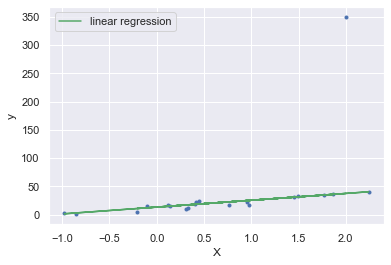

In [10]:
# TODO  (for visualization)
x = X[:, 0]
params_min = huber_lbfgs_l2(X=X, y=y, lbda=lbda, epsilon=epsilon)
y_pred = params_min[1:] * x + params_min[0]

print('coef = %.3f' %params_min[1])
print('intercept = %.3f' %params_min[0])

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()
# END TODO

<font color='blue'>
    
**Comments**
- We can easily visualize that the new model of linear regression is insensitive to the outliers and fits the points cloud both in presence and in absence of outliers.
- The intercept is not penalized with the regularization and thus still quite different from the true value that generates the data without the outlier (13.3 instead of 10).
- The coefficients are penalized and thus the slope is lower than previously, not attracted by the outlier anymore (12.1 instead 38.6 previously).
    
<font>

## Part 2: Huber Loss with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [11]:
def pobj_l1(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [12]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 6a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method.
    </li>
    </ul>
</div>

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Huber term without regularization term).

In [13]:
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1, grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list of x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = prox(x - step*grad(x, *grad_args), *prox_args)
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

<div class="alert alert-success">
    <b>QUESTION 6b:</b>
    <ul>
    <li>
        Implement the L1 and L2 proximal operators. You will pay attention to the intercept.
    </li>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [14]:
def prox_R2(params, reg=1.):
    # TODO
    prox_b = params[0] #pour l'intercept (non régularisé) le prox est l'identité
    prox_w = params[1:]/(2*reg + 1)
    params = np.concatenate((prox_b, prox_w), axis=None)
    # END TODO
    return params


def prox_R1(params, reg=1.):
    # TODO
    prox_b = params[0]
    prox_w = np.sign(params[1:])*np.maximum(np.abs(params[1:]) - reg, 0)
    params = np.concatenate((prox_b, prox_w), axis=None)
    # END TODO
    return params


def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)


def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

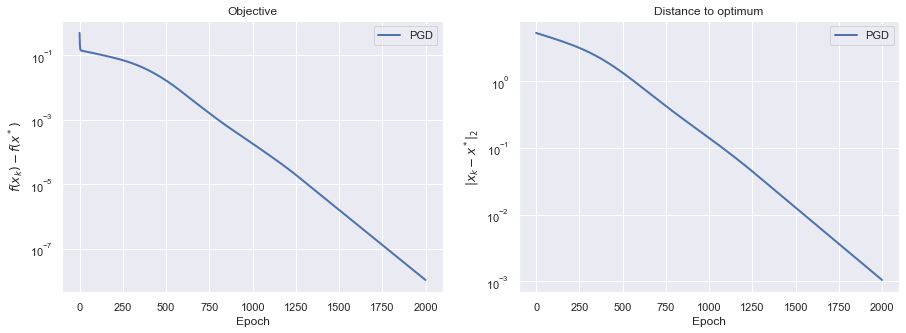

In [15]:
# Generate bigger data
X, y = make_regression(n_samples=500, n_features=100, random_state=0, noise=4.0, bias=10.0)
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 2000
lbda = 1.
epsilon = 1.

# TODO
def lipschitz_constant(X):
    n = X.shape[0]
    sv = np.linalg.svd(X)[1]
    return (2/n)*sv.max()**2

step = 1./lipschitz_constant(X) # Calcul du step=1/L avec L la CONSTANTE de LIPSCHITZ

def grad_huber_loss(params, X=X, y=y, epsilon=epsilon): #dérivée de la partie non régularisée
    n = X.shape[0]
    w = params[1:]
    b = params[0]
    grad_w = (-1/n) * X.T @ grad_huber(y - np.dot(X, w) - b, epsilon=epsilon)
    grad_b = -np.mean(grad_huber(y - np.dot(X, w) - b, epsilon=epsilon))
    return np.concatenate((grad_b, grad_w),axis=None)

x_min_l2, _ = pgd(x_init, grad_huber_loss, prox_l2, step, n_iter=10000, store_every=1, grad_args=(X, y, epsilon), prox_args=(step, lbda))
# END TODO

# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min=x_min_l2, args=(X, y, lbda, epsilon))
monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<font color='blue'>
    
**Comments**<br>
- We observe a linear decrease of the objective function alongside the number of epochs which is normal (here with a logscale) as we know that the convergence for the PGD is in $O \left( \frac{1}{T} \right)$ with $T$ the number of epochs.

<font>

Now for the $\ell_1$ regularization:

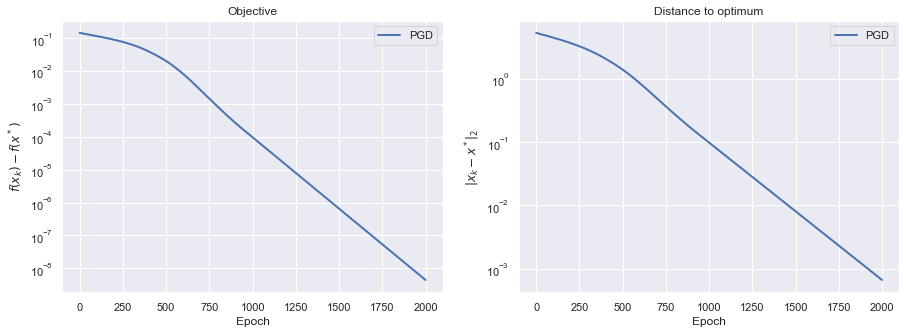

In [16]:
# Run PGD for L1
x_min_l1, _ = pgd(x_init, grad_huber_loss, prox_l1, step, n_iter=10000, store_every=1, grad_args=(X, y, epsilon), prox_args=(step, lbda))

monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, epsilon))
monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<font color='blue'>
    
**Comments**
- The convergence is the same with the $l1$ norm than with the $l2$ norm.
    
<font>

<div class="alert alert-success">
    <b>QUESTION 7:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [17]:
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1, grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        x_new = prox(y - step*grad(y, *grad_args), *prox_args)
        t_new = (1+ np.sqrt(1+4*t**2))/2
        y = x_new + ((t-1)/t_new)*(x_new-x)
        t = t_new
        x = x_new

        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

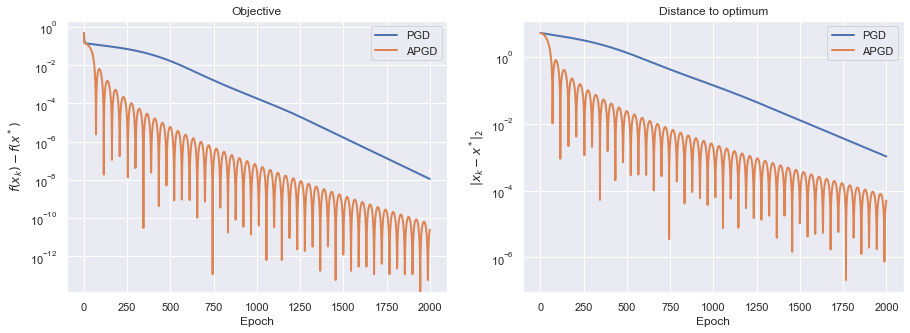

In [18]:
# TODO
monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min=x_min_l2, args=(X, y, lbda, epsilon))
monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

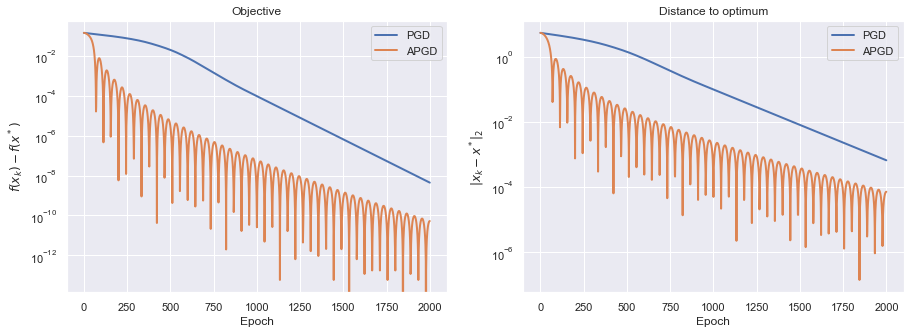

In [19]:
# TODO
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, epsilon))
monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

<font color='blue'>
    
**Comments**
- The convergence to the optimum solution of the APGD with the $l2$ or $l1$ norm is in $O \left( \frac{1}{T^2} \right)$, thus faster than PGD. We observe the characteristics oscillations of the APGD algo.

<font>

<div class="alert alert-success">
    <b>QUESTION 8:</b>
    <ul>
    <li>
        Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.
    </li>
    </ul>
</div>

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [20]:
# TODO
def prox_j_l2(w, step, lbda):
    prox_j = w/(1 + 2*step*lbda)
    return prox_j

def prox_j_l1(w, step, lbda):
    prox_j = np.sign(w)*np.maximum(np.abs(w) - step*lbda, 0)
    return prox_j

    grad_w = (-1/n) * X.T @ grad_huber(y - np.dot(X, w) - b, epsilon=epsilon)
    grad_b = -np.mean(grad_huber(y - np.dot(X, w) - b, epsilon=epsilon))
    
def pcd(x_init, grad_hub, prox_j, step, n_iter=100, store_every=1, grad_args=(), prox_args=()): 
    n_samples, n_features = X.shape
    x = x_init.copy()  #It corresponds to w = x[1:] and b = x[0]
    lips_const = (2/n_samples)*np.linalg.norm(X, axis=0)**2
    x_list = []
    step, lbda = prox_args
    
    for i in range(n_iter):
        #gradient descent step on b
        grad_b = -np.mean(grad_hub(y - np.dot(X, x[1:]) - x[0], epsilon=epsilon))
        step = 1/2
        x[0] = x[0] - step*grad_b

        for j in range(n_features):
            #gradient step on w_j
            grad_j = (-1/n_samples) * X[:,j].T  @ grad_hub(y - np.dot(X, x[1:]) - x[0], epsilon=epsilon) #could optimize the operations
            step = 1/lips_const[j]
            x[j+1] = prox_j(x[j+1] - step*grad_j, step, lbda)

        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

CPU times: user 19.1 s, sys: 1.51 s, total: 20.6 s
Wall time: 16.2 s


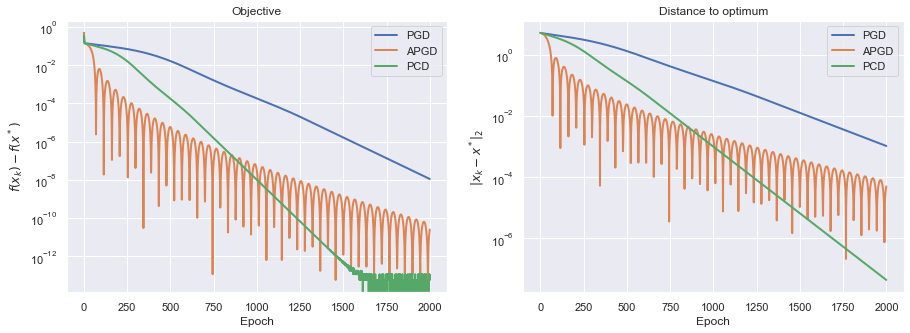

In [21]:
%%time
##Plots
monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min_l2, args=(X, y, lbda, epsilon))
monitor_pcd_l2.run(x_init, grad_huber, prox_j_l2, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

monitors = [monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)
# END TODO

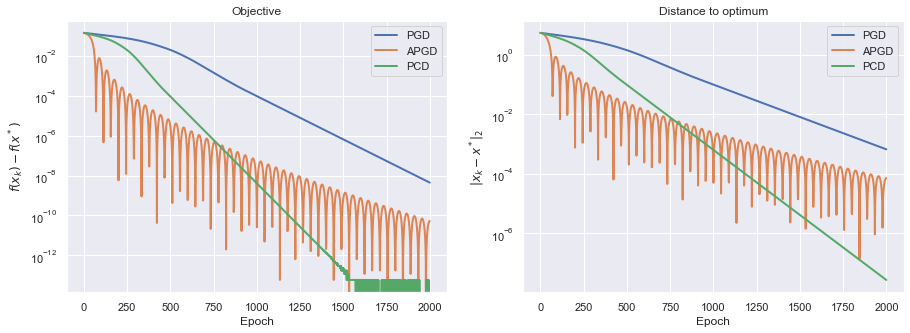

In [22]:
# TODO
#Plots
monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, epsilon))
monitor_pcd_l1.run(x_init, grad_huber, prox_j_l1, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)
# END TODO

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Compare the performance of the different solvers for different (simulated) problem sizes.
    </li>
    <li>
        What solver would you recommend for what problem and using what regularization?
    </li>
    </ul>
</div>

- Comparison of the performances

**For n_samples = 500 and n_features = 100** (see graphs above)


<font color='blue'>
    Analysis for n_samples = 500 and n_features = 100 with 20 informative <br>
    First, notice that with the cyclic coordinate descent, each epoch costs as much as the PGD (or APGD), ie. $O(nd)$. Thus we can compare number of epochs. APGD is faster for high precision (up to $10^{-6}$) and then PCD is faster for very high precision.

**For n_samples = 50 and n_features = 100**

In [23]:
# Generate new data
X, y = make_regression(n_samples=50, n_features=100, n_informative=20, random_state=0, noise=4.0, bias=10.0)

n_samples, n_features = X.shape
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y) # initialization of the bias term 
step = 1./lipschitz_constant(X)

In [24]:
x_min_l2, _ = pgd(x_init, grad_huber_loss, prox_l2, step, n_iter=10000, store_every=1, grad_args=(X, y, epsilon,), prox_args=(step, lbda))
x_min_l1, _ = pgd(x_init, grad_huber_loss, prox_l1, step, n_iter=10000, store_every=1, grad_args=(X, y, epsilon,), prox_args=(step, lbda))

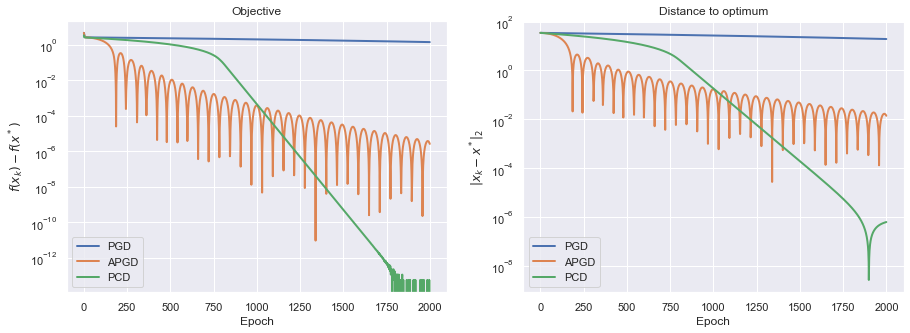

In [25]:
################################################################################################
#                                         For l2 norm
################################################################################################
x_min = x_min_l2
prox = prox_l2
prox_j = prox_j_l2
pobj = pobj_l2

# PGD
monitor_pgd = monitor(pgd, pobj, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pgd.run(x_init, grad_huber_loss, prox, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

# APGD
monitor_apgd = monitor(apgd, pobj, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_apgd.run(x_init, grad_huber_loss, prox, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

# PCD
monitor_pcd = monitor(pcd, pobj, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd.run(x_init, grad_huber, prox_j, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

# Display results
monitors = [monitor_pgd, monitor_apgd, monitor_pcd]
solvers = ["PGD", "APGD", 'PCD']
plot_epochs(monitors, solvers)

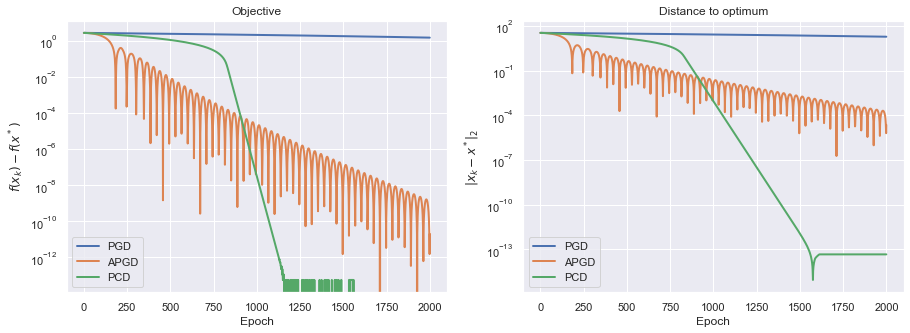

In [26]:
######################################################################################################
#                                         For l1 norm
######################################################################################################
x_min = x_min_l1
prox = prox_l1
prox_j = prox_j_l1
pobj = pobj_l1

# PGD
monitor_pgd = monitor(pgd, pobj, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pgd.run(x_init, grad_huber_loss, prox, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

# APGD
monitor_apgd = monitor(apgd, pobj, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_apgd.run(x_init, grad_huber_loss, prox, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

# PCD
monitor_pcd = monitor(pcd, pobj, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd.run(x_init, grad_huber, prox_j, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

# Display results
monitors = [monitor_pgd, monitor_apgd, monitor_pcd]
solvers = ["PGD", "APGD", 'PCD']
plot_epochs(monitors, solvers)

<font color='blue'>
    Analysis for n_samples = 50 and n_features = 100 with 20 informative <br>
    PGD is particulary slow for this configuration. This time it is around $10^{-4}$ that PCD becomes faster than APGD.<br/>

**For n_samples = 500 and n_features = 25**

In [27]:
# Generate new data
X, y = make_regression(n_samples=500, n_features=24, n_informative=20, random_state=0, noise=4.0, bias=10.0)

n_samples, n_features = X.shape
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
step = 1./lipschitz_constant(X)

In [28]:
x_min_l2, _ = pgd(x_init, grad_huber_loss, prox_l2, step, n_iter=10000, store_every=1, grad_args=(X, y, epsilon,), prox_args=(step, lbda))
x_min_l1, _ = pgd(x_init, grad_huber_loss, prox_l1, step, n_iter=10000, store_every=1, grad_args=(X, y, epsilon,), prox_args=(step, lbda))

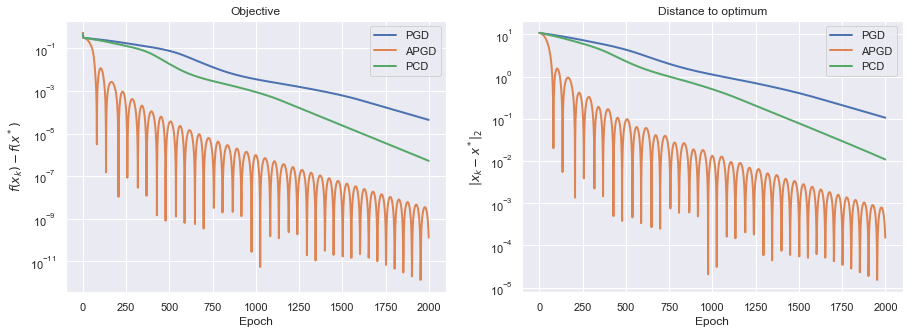

In [29]:
#######################################################################################################
#                                          For l2 norm
#######################################################################################################
x_min = x_min_l2
prox = prox_l2
prox_j = prox_j_l2
pobj = pobj_l2

# PGD
monitor_pgd = monitor(pgd, pobj, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pgd.run(x_init, grad_huber_loss, prox, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

# APGD
monitor_apgd = monitor(apgd, pobj, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_apgd.run(x_init, grad_huber_loss, prox, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

# PDC
monitor_pcd = monitor(pcd, pobj, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd.run(x_init, grad_huber, prox_j, step, n_iter, grad_args=(X, y, epsilon), prox_args=(step, lbda))

# Display results
monitors = [monitor_pgd, monitor_apgd, monitor_pcd]
solvers = ["PGD", "APGD", 'PCD']
plot_epochs(monitors, solvers)

<font color='blue'>
    Analysis for n_samples = 100 and n_features = 25 with 20 informative <br>
    The results for the $l1$ norm are not displayed because identic as the one for $l2$. This time, with much less features and the same number of informative one, we see that the APGD is better whatever the precision compared to the PGD and the PCD.

- What solver would you recommend for what problem and using what regularization?

<font color='blue'>
    For the two first situations we would prefer the $l1$ norm as the number of features is way larger than the number of informative ones (sparse). Regarding to the solver, APGD seems to be the fastest one to reach a good precision but if one is interested in having more accurate precision, it should consider PCD. <br>
    In the last situation, when all (or almost all) the features are informatives, the type of regularization does not really impact the output and the APGD solver is the fastest one in both situations.

# Part 3: Application

You will now apply your solver to an environment dataset. Given 2 features:

 - LNOxEm log of hourly sum of NOx emission of cars on this motorway in arbitrary units.
 - sqrtWS Square root of wind speed [m/s].

The objective is to predict:

 - log of hourly mean of NOx concentration in ambient air [ppb] next to a highly frequented motorway

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration. Also, don't be surprised if Huber loss offers little to no benefit. Again it's just an illustration.

Let's first inspect the dataset:

In [30]:
import pandas as pd

df = pd.read_csv('NOxEmissions.csv', index_col=0).drop(['julday'], axis=1)
df.head()

,LNOx,LNOxEm,sqrtWS
193,4.457250,5.536489,0.856446
194,4.151827,5.513000,1.016612
195,3.834061,4.886994,1.095445
196,4.172848,5.138912,1.354068
197,4.322807,5.666518,1.204159


Now let's extract `X` and `y`

In [31]:
X = df.loc[:, ['LNOxEm', 'sqrtWS']].values
y = df['LNOx']
X.shape, y.shape

((8088, 2), (8088,))

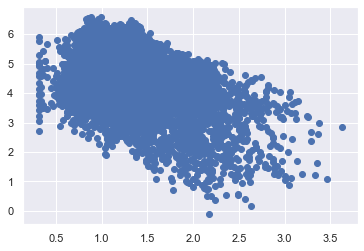

In [32]:
plt.scatter(X[:, 1], y);

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 9bis:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [33]:
from sklearn.base import BaseEstimator, RegressorMixin

class HuberRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a Huber loss
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.
        
    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', epsilon=1., max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.solver = solver
        assert epsilon > 0.
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        # TODO
        x_init = np.zeros(n_features + 1)
        x_init[0] = np.mean(y)
        step = 1./lipschitz_constant(X)
        
        if self.solver=='pcd':
            grad = grad_huber
            prox = globals()['prox_j_' + self.penalty]
        else:
            prox = globals()['prox_' + self.penalty]
            grad = grad_huber_loss
            
        solv = globals()[self.solver]
    
        x, __ = solv(x_init, grad, prox, step=step, n_iter=self.max_iter, grad_args=(X, y, self.epsilon), prox_args=(step, self.lbda))
        
        # END TODO
        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_

    
    def score(self, X, y):
        """Score using negative mean absolute error
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
            
        Returns
        -------
        score : float
            The negative mean absolute error.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(np.abs(y - self.predict(X)))

In [57]:
%%time
for solver in ['pgd', 'apgd', 'pcd']: #, 'pcd'
    clf = HuberRegressor(lbda=1., penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L2: %s   \t-   MAE : %.4f' % (solver, -clf.score(X, y)))

for solver in ['pgd', 'apgd', 'pcd']: #, 'pcd'
    clf = HuberRegressor(lbda=1., penalty='l1', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L1: %s   \t-   MAE : %.4f' % (solver, -clf.score(X, y)))

Solver with L2: pgd   	-   MAE : 0.6226
Solver with L2: apgd   	-   MAE : 0.5734
Solver with L2: pcd   	-   MAE : 0.5737
Solver with L1: pgd   	-   MAE : 0.7131
Solver with L1: apgd   	-   MAE : 0.7131
Solver with L1: pcd   	-   MAE : 0.7131
CPU times: user 2min 35s, sys: 1min 47s, total: 4min 22s
Wall time: 2min 13s


<div class="alert alert-success">
    <b>QUESTION 10:</b>
    <ul>
        <li>
            Compare the cross-validation performance of your model (using `cross_val_score`) with a Ridge or Lasso regression models using as scoring metric the "mean absolute error" (MAE).
        </li>
        <li>
            You will check that the Huber model matches Ridge when epsilon is large. Pay attention to how the loss is scaled in scikit-learn for Ridge (no normalization by 1/n_samples).
        </li>
        <li>
            You will comment on the running time of your solver to reach their optimal prediction performance.
        </li>
    </ul>
</div>

To score your model with MAE using cross_val_score you need to pass as parameter `scoring='neg_mean_absolute_error'`.

In [34]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score

- Cross-validation performance of the model

In [35]:
cv_score_ridge = - cross_val_score(Ridge(), X, y, scoring='neg_mean_absolute_error', cv=3)
cv_score_lasso = - cross_val_score(Lasso(), X, y, scoring='neg_mean_absolute_error', cv=3)
print("Ridge: MAE = %.3f" %np.mean(cv_score_ridge))
print("Lasso: MAE = %.3f" %np.mean(cv_score_lasso))

Ridge: MAE = 0.451
Lasso: MAE = 0.726


MAE of our model with apgd solver as it gives the smallest MAE

In [36]:
%%time
solver = 'apgd'
cv_score_huber_l2 = -cross_val_score(HuberRegressor(penalty='l2', solver=solver), X, y, scoring='neg_mean_absolute_error', cv=3)
cv_score_huber_l1 = -cross_val_score(HuberRegressor(penalty='l1', solver=solver), X, y, scoring='neg_mean_absolute_error', cv=3)
print('Hubert with L2 : MAE = %.3f' % np.mean(cv_score_huber_l2))
print('Hubert with L1 : MAE = %.3f' % np.mean(cv_score_huber_l1))

Hubert with L2 : MAE = 0.594
Hubert with L1 : MAE = 0.723
CPU times: user 5min 39s, sys: 28.6 s, total: 6min 7s
Wall time: 3min 27s


<font color='blue'>
    So we see that the MAE are quite close for the $l1$ penalised Huber problem compared with the Lasso regression. For the $l2$ penalised Huber problem we have a larger MAE compared with the Ridge regression but we need to modify a little bit the parameter of the problem in order to compare them properly as we explain below.

- Check that the Huber model matches Ridge when epsilon is large

<font color='blue'>
    Difference between our problem:<br>
$$\frac{1}{n}\sum_{i=1}^{n}H_{\epsilon}(y_i-x_i^Tw-b) + \lambda \Vert w \Vert$$
and the problem solved by scikit learn is the following: <br>
$$\Vert y-Xw-b \Vert ^2 + \alpha \Vert w \Vert$$

So to match both models we need: 
$$\alpha = n*\lambda$$

In [37]:
cv_score_ridge = - cross_val_score(Ridge(alpha=X.shape[0]*lbda), X, y, scoring='neg_mean_absolute_error', cv=5)
print("Ridge (modified): MAE = %.3f" %np.mean(cv_score_ridge))

Ridge (modified): MAE = 0.580


In [41]:
#With PGD
solver = 'pgd'
cv_score_huber_l2 = -cross_val_score(HuberRegressor(lbda=1., penalty='l2', solver=solver, epsilon=50), X, y, scoring='neg_mean_absolute_error', cv=5)
print('Hubert with L2 for epsilon = 100  : MAE = %.3f' % np.mean(cv_score_huber_l2))

Hubert with L2 for epsilon = 100  : MAE = 0.585


In [39]:
%%time
#With APGD
solver = 'apgd'
cv_score_huber_l2 = -cross_val_score(HuberRegressor(lbda=1., penalty='l2', solver=solver, epsilon=100), X, y, scoring='neg_mean_absolute_error', cv=3)
print('Hubert with L2 for epsilon = 100  : MAE = %.3f' % np.mean(cv_score_huber_l2))

Hubert with L2 for epsilon = 100  : MAE = 0.573
CPU times: user 2min 27s, sys: 12.3 s, total: 2min 39s
Wall time: 1min 29s


<font color='blue'>
    With $\epsilon$ big we see that MAE of the Huber model is getting closer to the MAE of the ridge regression (modified with $\alpha = n\lambda$). <br> This is explained by the fact that when $\epsilon$ is growing the interval on which the Huber function matches the square function is growing and so the Huber function is closer and closer as the square function.

- Running time of your solver to reach their optimal prediction performance

In [42]:
# Huber regressor with l2
for solver in ['pgd', 'apgd', 'pcd']:
    t0 = time.time()
    huber_clf = HuberRegressor(lbda=1., penalty='l2', max_iter=n_iter, solver=solver, epsilon=1.)
    huber_clf.fit(X, y)
    t1 = time.time()
    print(solver)
    print('Time: %.1f s' %(t1-t0))

# Ridge
t0 = time.time()
clf = Ridge(alpha=X.shape[0]*lbda)
clf.fit(X, y)
t1 = time.time()
print('ridge')
print('Time %.3f s' %(t1-t0))

pgd
Time: 45.8 s
apgd
Time: 39.8 s
pcd
Time: 57.6 s
ridge
Time 0.005 s


In [65]:
# Huber regressor with l1
for solver in ['pgd', 'apgd', 'pcd']:
    t0 = time.time()
    huber_clf = HuberRegressor(lbda=1., penalty='l1', max_iter=n_iter, solver=solver, epsilon=1.)
    huber_clf.fit(X, y)
    t1 = time.time()
    print(solver)
    print('Time: %.1f s' %(t1-t0))

# Lasso
t0 = time.time()
clf = Lasso()
clf.fit(X, y)
t1 = time.time()
print('lasso')
print('Time %.3f s' %(t1-t0))

pgd
Time: 36.2 s
apgd
Time: 35.9 s
pcd
Time: 52.8 s
lasso
Time 0.002 s


<font color='blue'>
    From our observation we can see that lasso and ridge which are build-in classes are extremly fast and run in under 1 second. For our regressors, PCD is the slowest of the three. Regarding the two remaining, it seems that APGD is a few seconds faster than PGD as its name suggests it.